# ⭐️ 프로젝트: CAM을 만들고 평가해 보자

이번 시간에는 CAM(Class Activation Map)을 얻기 위한 방법 중 기본 CAM과 Grad-CAM을 구현해보고 이를 시각화해 보겠습니다. 그리고 CAM을 활용해서 물체의 위치를 찾는 object detection을 수행하고 이를 정답 데이터와 비교해 보겠습니다.

## ✅ 실습목표
* Classification model로부터 CAM을 얻어낼 수 있다.
* CAM으로 물체의 위치를 찾을 수 있다.
* CAM을 시각화 비교할 수 있다.

## ✅ 학습 내용
* CAM, Grad-CAM용 모델 준비하기
* CAM
* Grad-CAM
* Detection with CAM

## 데이터셋 준비하기    

-----------


[standard_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs) 데이터셋을 사용하도록 하겠습니다.  

* 20 종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 **바운딩 박스(bounding box) 정보를 포함**하고 있습니다.

**먼저 필요한 라이브러리들을 불러오겠습니다!**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

**GPU환경을 확인해보도록 하겠습니다.**

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

tfds.load()를 활용해서 데이터셋을 다운로드 하겠습니다.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

**tfds.show_examples() 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인**

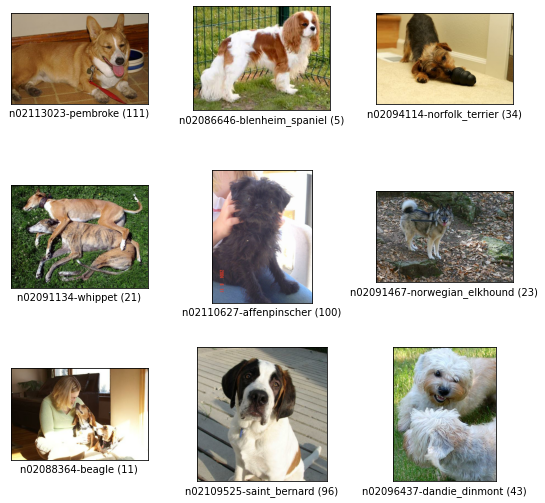

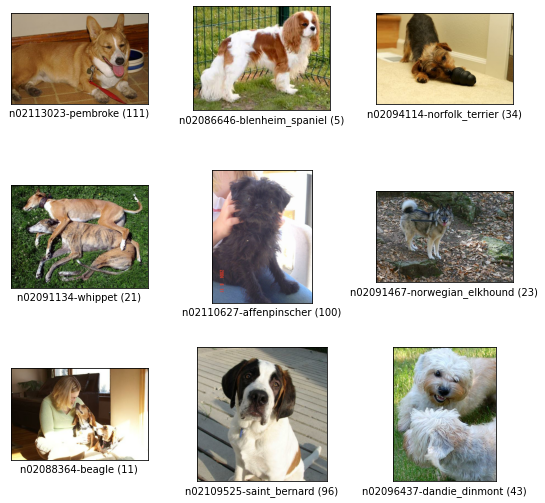

In [4]:
tfds.show_examples(ds_train, ds_info)

**평가용 데이터셋도 눈으로 확인**

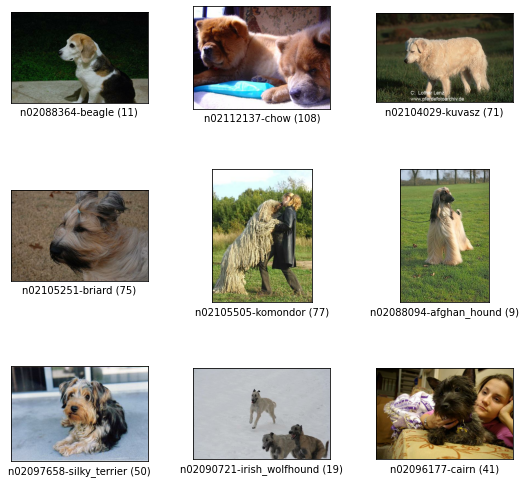

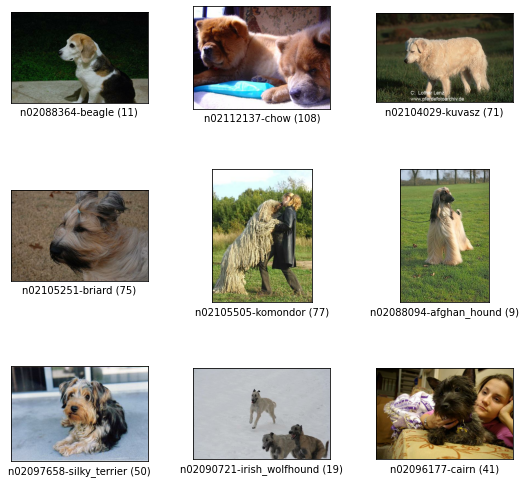

In [5]:
tfds.show_examples(ds_test, ds_info)

## 물체의 위치정보

데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인해 보겠습니다.

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

🔼 bbox(바운딩 박스)는 물체의 위치를 사각형 영역으로 표기하는 방법입니다. 위에서 확인한 바로는 BBoxFeature이라는 타입으로 정의되어있습니다.

### ▶️ 바운딩 박스를 표시하는 방법들

----------------------

바운딩 박스를 라벨링하는 방법은 아주 다양합니다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법입니다.    

* **'xywh'** 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 **너비 w와 높이 h**를 표기하는 방법입니다.
    * (예) (x_center, y_center, width, height)
    * x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.      
    
    
* **'minmax'** 는 바운딩박스를 이루는 좌표의 **최소값과 최대값**을 통해 표기하는 방법입니다.
    * (예) (x_min, x_max, y_min, y_max)
    * 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.

## CAM 구현하기

### 1) CAM을 위한 모델 만들기     


------  


미리 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.    

* 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어

CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없지만, 마지막 fully connected layer 대신 GAP을 사용해주어야 합니다.   
ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있습니다.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output

preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 2) CAM 모델 학습하기

In [9]:
# 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 수행
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    # input에 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 여기서는 제외
    # 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기때문
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 위에서 수행한 것을 포함하여 apply_normalize_on_dataset()에서 배치를 구성
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 377s 467ms/step - loss: 3.1523 - accuracy: 0.2888 - val_loss: 3.1342 - val_accuracy: 0.2472
Epoch 2/20
750/750 [==============================] - 343s 458ms/step - loss: 0.9266 - accuracy: 0.7386 - val_loss: 1.0194 - val_accuracy: 0.6952
Epoch 3/20
750/750 [==============================] - 343s 458ms/step - loss: 0.3234 - accuracy: 0.9237 - val_loss: 0.9458 - val_accuracy: 0.7217
Epoch 4/20
750/750 [==============================] - 344s 458ms/step - loss: 0.0903 - accuracy: 0.9893 - val_loss: 0.9174 - val_accuracy: 0.7346
Epoch 5/20
750/750 [==============================] - 344s 458ms/step - loss: 0.0339 - accuracy: 0.9980 - val_loss: 0.9178 - val_accuracy: 0.7404
Epoch 6/20
750/750 [==============================] - 343s 458ms/step - loss: 0.0185 - accuracy: 0.9991 - val_loss: 0.9275 - val_accuracy: 0.7441
Epoch 7/20
750/750 [==============================] - 343s 458ms/step - loss: 0.0138 - accuracy: 0.9997 - val_loss: 0.9463 -

#### 위에서 학습시킨 가중치를 저장하겠습니다.

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model2.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## CAM

CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [16]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

84


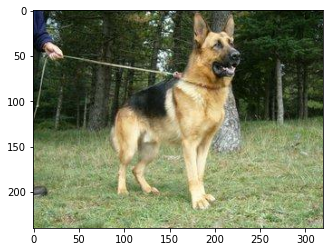

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

CAM을 생성하기 위해 이전 스텝에서 학습한 모델을 불러와 볼께요

In [18]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model2.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 생성하기 위해 필요한 것     

(1) 특성 맵    
(2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치     
(3) 원하는 클래스의 출력값     

이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하기위해 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화하겠습니다.     
이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어봅시다!

In [19]:
# generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 
# 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, 
# feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 
# 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

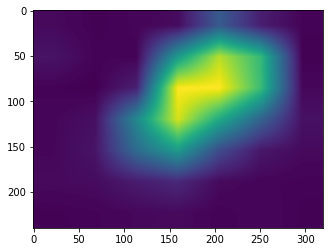

In [21]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [22]:
# CAM 이미지를 원본 이미지와 합치기
# 두 이미지의 투명도를 조정하고 하나의 이미지에서 원본과 CAM을 겹쳐 보여줌
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

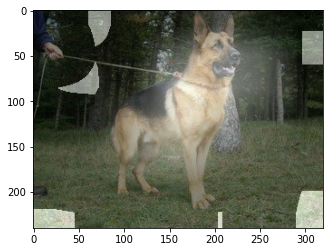

In [23]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기     

--------------

Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용해보도록 하죠!

67


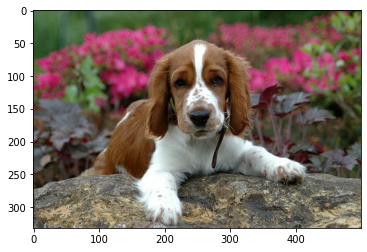

In [24]:
# 새로운 이미지를 뽑아보도록 하겠습니다.
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### grad_cam
* 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다.     

* 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됩니다.

**Grad-CAM**은 이번에는 어떤 레이어든 **CAM 이미지를 뽑아낼 수 있으므로**, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야합니다.

In [25]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

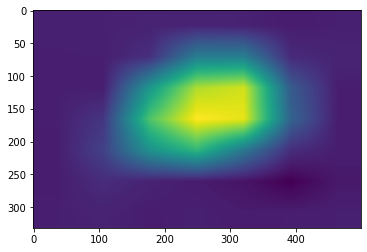

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

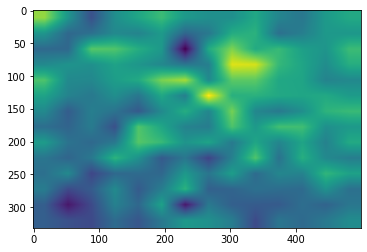

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

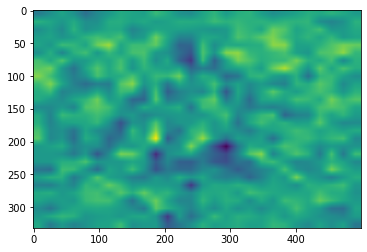

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

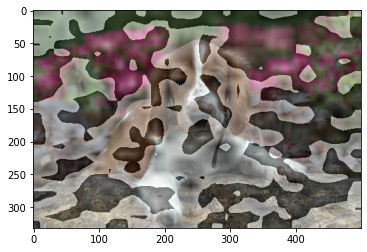

In [29]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Detection with CAM

## 바운딩 박스 구하기

### bbox from CAM

67


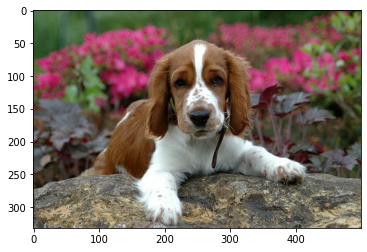

In [30]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

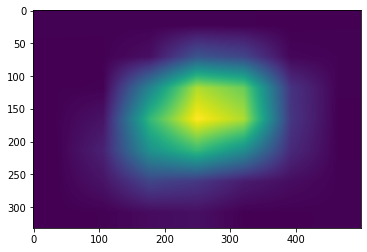

In [31]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [32]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh  # 역치값 이하의 바운딩 박스는 없앱니다.
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # 사각형 찾기
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)  # 회전된 바운딩 박스 얻기
    rect = cv2.boxPoints(rotated_rect)  # 꼭지점으로 변환
    rect = np.int0(rect)  # int 자료형으로 변환
    return rect

In [33]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 73, 297],
       [ 81,  26],
       [443,  37],
       [435, 308]])

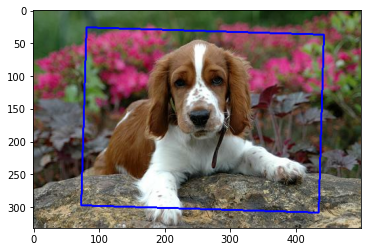

In [34]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

### bbox from Grad-CAM

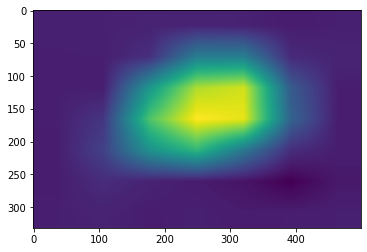

In [35]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [36]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ 66,  29],
       [447,  26],
       [448, 254],
       [ 68, 257]])

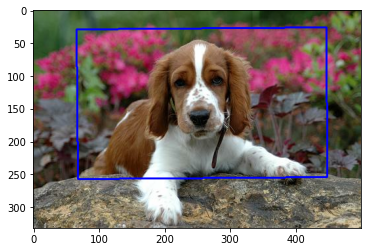

In [37]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

## IoU(Intersection Over Union) 구하기    


--------

IoU(Intersection over Union)는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값

In [38]:
# 위에서 구한 rect를 minmax bbox 형태로 치환하는 함수
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [40]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0783132530120482, 0.146, 0.927710843373494, 0.886]

In [41]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [42]:
# Grad-CAM의 bbox
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.0783132530120482, 0.132, 0.7740963855421686, 0.896]

In [43]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [46]:
# CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
get_iou(pred_bbox, item['objects']['bbox'][0])

0.8045707738491713

In [47]:
# Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.6413837821769828

||CAM|Grad-CAM|
|:---:|:-------------------------------------------:|:--------------------------------------:|
|image|<img width="300" alt="cam" src="https://user-images.githubusercontent.com/63396019/136975291-8477ff66-6d48-4ad3-8a1b-95e20c2ded80.png">|<img width="300" alt="스크린샷 2021-10-12 오후 11 13 25" src="https://user-images.githubusercontent.com/63396019/136975377-60998d9a-1e99-46ea-9fee-c443c8f824e9.png">|
|bbox|<img width="300" alt="camcam" src="https://user-images.githubusercontent.com/63396019/136976721-d9cd62e3-e9ad-4c3c-80fa-a14afda2559e.png">|<img width="300" alt="스크린샷 2021-10-12 오후 11 13 29" src="https://user-images.githubusercontent.com/63396019/136975571-cc264e7d-3dde-45b6-975a-0e75c20dc83e.png">|
|IoU|0.80|0.64|

▶️ 위에 강아지 사진을 보면 CAM은 얼굴뿐만아니라 두 발까지 특징을 추출했지만 Grad-CAM은 주로 얼굴부분만 특징을 추출하고 있는게 보이죠! 따라서 CAM이 Grad-CAM보다 조금 더 넓은 부분을 집중하는 것을 알 수 있습니다.       


▶️ IoU도 CAM이 좀 더 높게 나온 것을 볼 수 있습니다.

# 🌟 루브릭

|평가문항|상세기준|
|:-----------|:----------------|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|